In [1]:
import glob
import os
import pprint
import traceback
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
 def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        'compressedHistograms': 1,
        'images': 1,
        'scalars': 0,  # 0 means load all
        'histograms': 1,
    }
    runlog_data = pd.DataFrame({'metric': [], 'value': [], 'step': []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()['scalars']
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {'metric': [tag] * len(step), 'value': values, 'step': step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print('Event file possibly corrupt: {}'.format(path))
        traceback.print_exc()
    return runlog_data

In [3]:
experiments = []
for agent in ['sac', 'sacae', 'drq']:
    for robot in [True, False]:
        for pr in [True, False]:
            experiments.append(f'{agent}_robot-{robot}_pr-{pr}')

In [5]:
path = '../../../output/final/fetch-reach-final/'
exp_dict = {}
for exp in experiments:
    for i in range(3):
        tb = glob.glob(os.path.join(path, f'{exp}_{i}/tb/*'))
        if exp in exp_dict:
            exp_dict[exp].append(tb[0])
        else:
            exp_dict[exp] = tb

In [6]:
exp_dict = {k: list(map(lambda x: tflog2pandas(x), iter(v))) for k, v in exp_dict.items()}

In [7]:
exp_dict2 = {}
for k, v in exp_dict.items():
    df = pd.DataFrame()
    for frame in v:
        df = df.append(frame, ignore_index=True)
    split = k.split('_')
    name = split[0]
    if split[1] == 'robot-True':
        name += '+robot'
    if split[2] == 'pr-True':
        name += '+teacher'
    if len(split) > 3 and split[3] == 'a-05':
        name += '_alpha=0.5'
    df['algo'] = name
    exp_dict2[k] = df

In [8]:
logs = pd.DataFrame()
for frame in exp_dict2.values():
    logs = logs.append(frame, ignore_index=True)

In [9]:
logs = logs.sort_values(by=['algo'])

In [34]:
logs[logs['metric']=='train/success_rate']

,metric,value,step,algo
830041,train/success_rate,0.00,950.0,drq+robot+teacher_alpha=0.5
830042,train/success_rate,0.00,1000.0,drq+robot+teacher_alpha=0.5
830043,train/success_rate,0.00,1050.0,drq+robot+teacher_alpha=0.5
830044,train/success_rate,0.00,1100.0,drq+robot+teacher_alpha=0.5
830045,train/success_rate,0.00,1150.0,drq+robot+teacher_alpha=0.5
...,...,...,...,...
593317,train/success_rate,0.00,7350.0,sacae+teacher_alpha=0.5
593318,train/success_rate,0.00,7400.0,sacae+teacher_alpha=0.5
593319,train/success_rate,0.00,7450.0,sacae+teacher_alpha=0.5
593321,train/success_rate,0.00,7550.0,sacae+teacher_alpha=0.5


In [10]:
state_paths = ['../../../output/fetch-reach-ae-ensemble/SAC_ensemble_0/tb/events.out.tfevents.1663492942.use.65737.0',
              '../../../output/fetch-reach-ae-ensemble/SAC_ensemble_1/tb/events.out.tfevents.1663494533.use.65737.1',
              '../../../output/fetch-reach-ae-ensemble/SAC_ensemble_2/tb/events.out.tfevents.1663496107.use.65737.2']

state_frame = pd.DataFrame()
for path in state_paths:
    df = tflog2pandas(path)
    df['algo'] = 'sac-state'
    state_frame = state_frame.append(df, ignore_index=True)

In [11]:
def plot(data, metric, name, y_low, y_high, image_name=None, color_palette="colorblind", dashes=None, legend=True, size=(20,10), legend_offset=-0.11, legend_ncol=5):
    fig = plt.figure(figsize=size)
    fig.patch.set_facecolor('white')
    plt.ticklabel_format(scilimits=[-5,3])
    

    # set style and context
    sns.set_context("notebook")
    sns.set(style='whitegrid', font_scale=2)

    # create graph
    graph = sns.lineplot(data=data[data['metric']==metric], 
                        x='step', 
                        y='value', 
                        hue='algo',
                        style='algo',
                        ci='sd',
                        palette=color_palette,
                        dashes=dashes)

    # set legend options
    handles, labels = graph.get_legend_handles_labels()
    if legend:
        fig.legend(loc='lower center', 
                   bbox_to_anchor=(0.5, legend_offset), 
                   fancybox=True, 
                   shadow=True, 
                   ncol=legend_ncol, 
                   prop={'size': 19})

    # graph options
    graph.legend([],[], frameon=False)
    graph.set(xlabel='Environment Steps', ylabel=name)
    #graph.title.set_text('FetchReach')
    #graph.title.set_size(26)
    graph.set_ylim(y_low, y_high)
    graph.set_xlim(0, 100000)
    #fig.tight_layout(pad=2.0)
    if image_name != None:
        plt.savefig(image_name, bbox_inches='tight')#, pad_inches=0.1)

In [107]:
all_logs = state_frame.append(logs, ignore_index=True)

In [279]:
all_logs.to_pickle('results/reach/graph_data.pkl')

In [3]:
all_logs = pd.read_pickle('results/reach/graph_data.pkl')

In [22]:
all_logs = all_logs.append(logs, ignore_index=True)

In [23]:
dashes = {algo: () if i <= 9 else (6,4) for i, algo in enumerate(all_logs['algo'].unique())}

In [24]:
colors = {algo: sns.color_palette('colorblind', all_logs['algo'].nunique())[i] for i, algo in enumerate(all_logs['algo'].unique())}

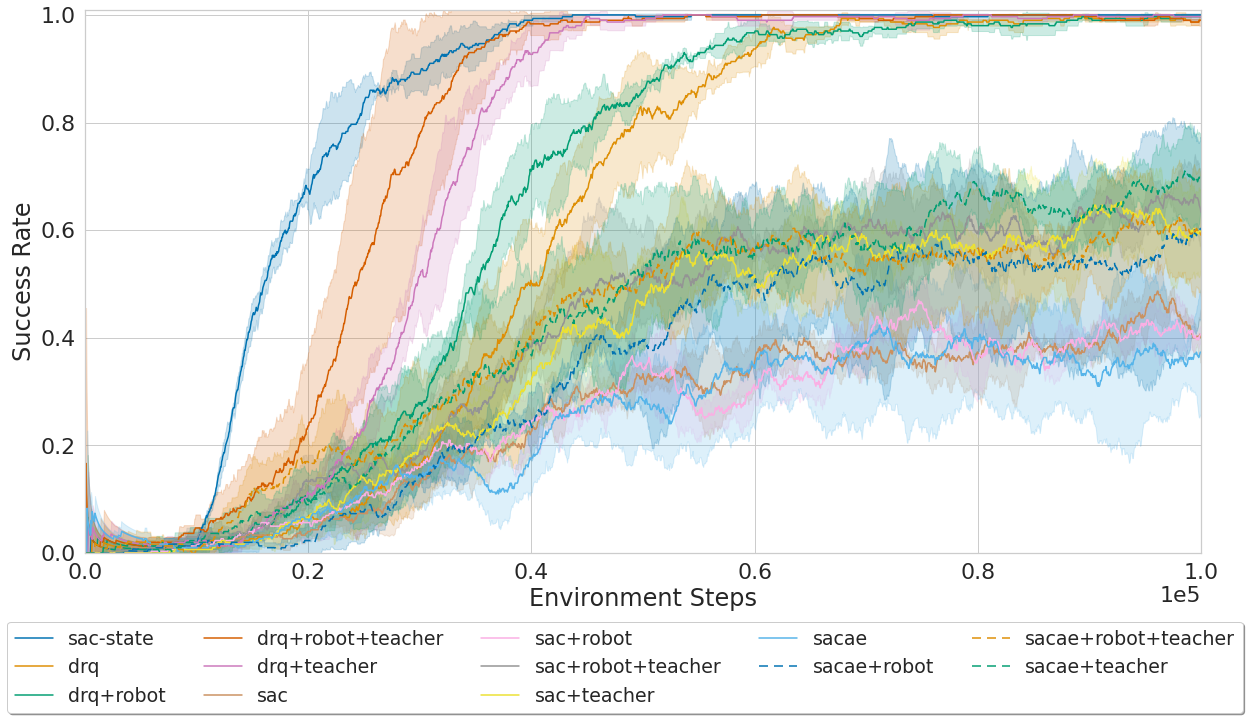

In [76]:
plot(all_logs, 'train/success_rate', 'Success Rate', 0, 1.01, 'results/reach/all.png', colors, dashes)

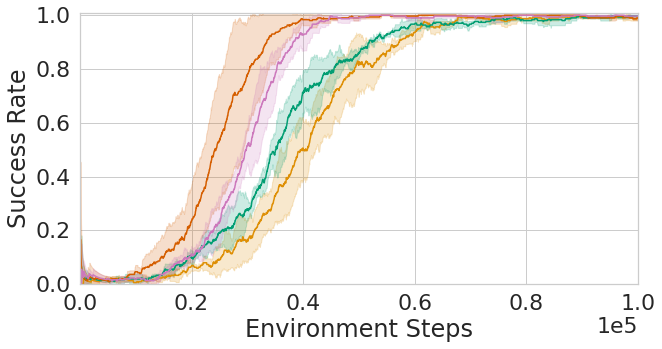

In [273]:
data = all_logs[all_logs['algo'].isin(['drq', 'drq+robot', 'drq+teacher', 'drq+robot+teacher'])]
plot(data, 'train/success_rate', 'Success Rate', 0, 1.01, 'results/reach/drq.png', colors, dashes, False, (10,5))

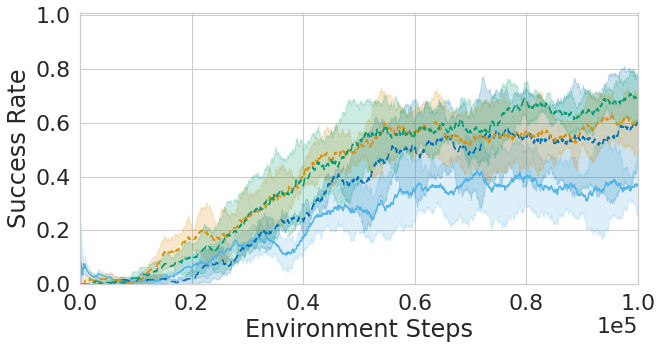

In [274]:
data = all_logs[all_logs['algo'].isin(['sacae', 'sacae+robot', 'sacae+teacher', 'sacae+robot+teacher'])]
plot(data, 'train/success_rate', 'Success Rate', 0, 1.01, 'results/reach/sacae.png', colors, dashes, False, (10,5))

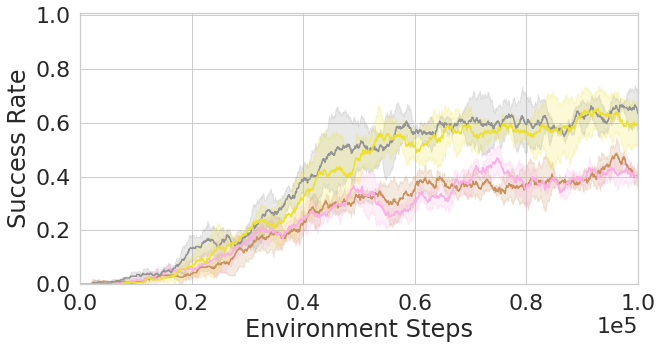

In [275]:
data = state_frame.append(logs, ignore_index=True)
data = data[data['algo'].isin(['sac', 'sac+robot', 'sac+teacher', 'sac+robot+teacher'])]
plot(data, 'train/success_rate', 'Success Rate', 0, 1.01, 'results/reach/sac.png', colors, dashes, False, (10,5))

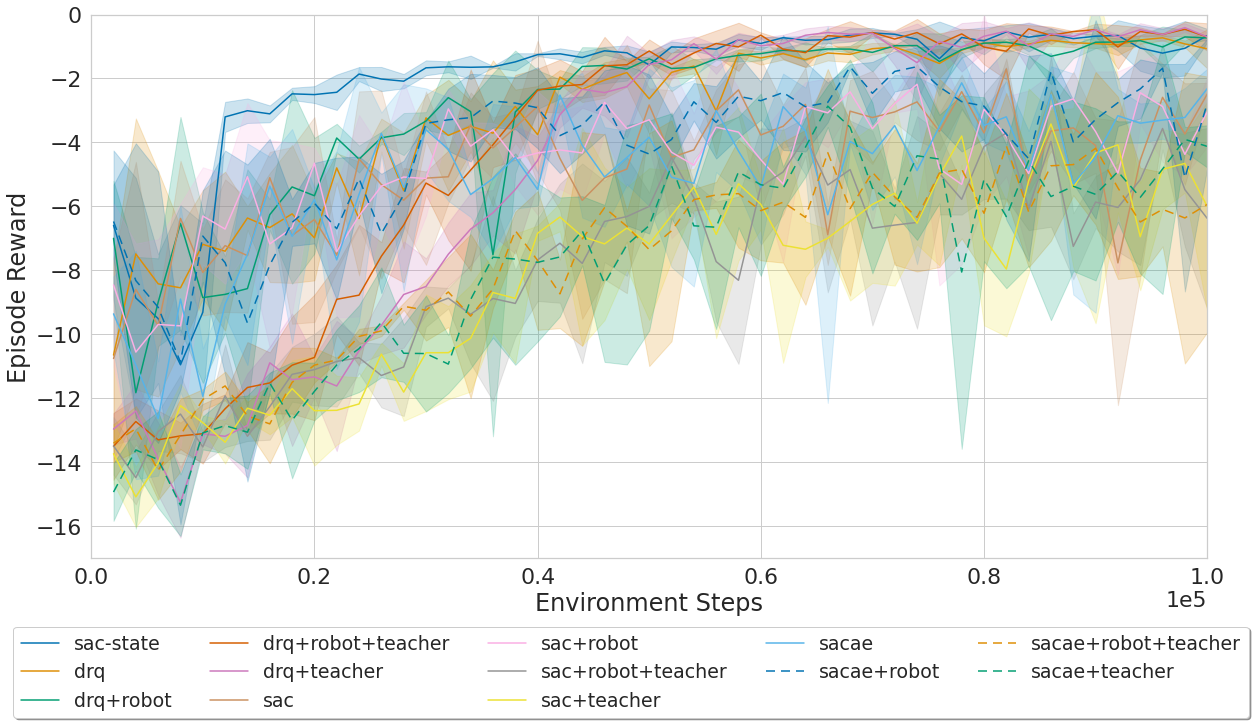

In [38]:
plot(all_logs[all_logs['step'] % 2000 == 0], 'train/episode_reward', 'Episode Reward', -17, 0, 'results/reach/reward_all.png', color_palette=colors, dashes=dashes)

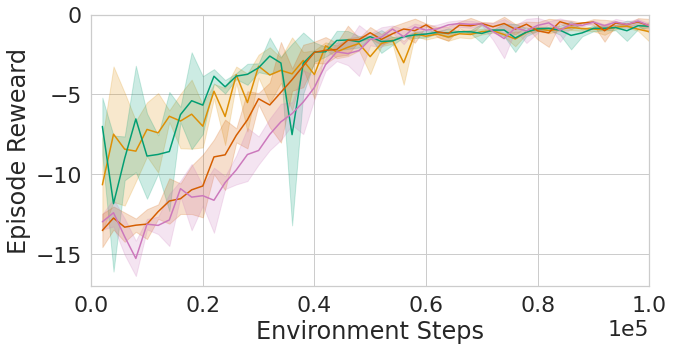

In [37]:
data = all_logs[all_logs['algo'].isin(['drq', 'drq+robot', 'drq+teacher', 'drq+robot+teacher'])]
plot(data[data['step'] % 2000 == 0], 'train/episode_reward', 'Episode Reweard', -17, 0, 'results/reach/reward_drq.png', colors, dashes, False, (10,5))

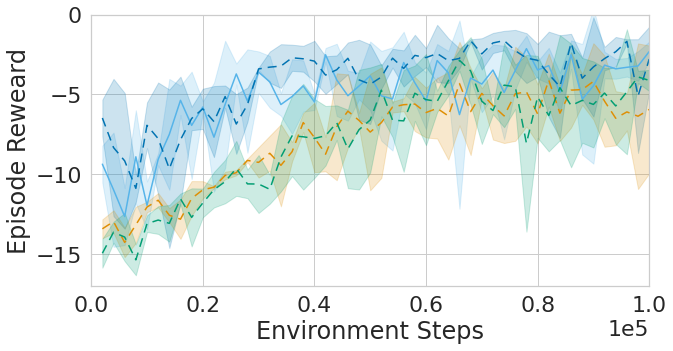

In [27]:
data = all_logs[all_logs['algo'].isin(['sacae', 'sacae+robot', 'sacae+teacher', 'sacae+robot+teacher'])]
plot(data[data['step'] % 2000 == 0], 'train/episode_reward', 'Episode Reweard', -17, 0, 'results/reach/reward_sacae.png', colors, dashes, False, (10,5))

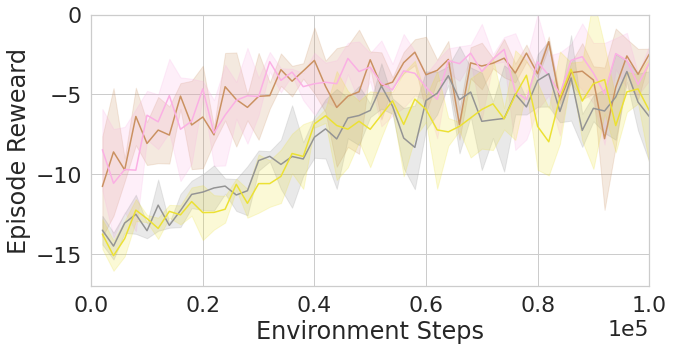

In [30]:
data = all_logs[all_logs['algo'].isin(['sac', 'sac+robot', 'sac+teacher', 'sac+robot+teacher'])]
plot(data[data['step'] % 2000 == 0], 'train/episode_reward', 'Episode Reweard', -17, 0, 'results/reach/reward_sac.png', colors, dashes, False, (10,5))

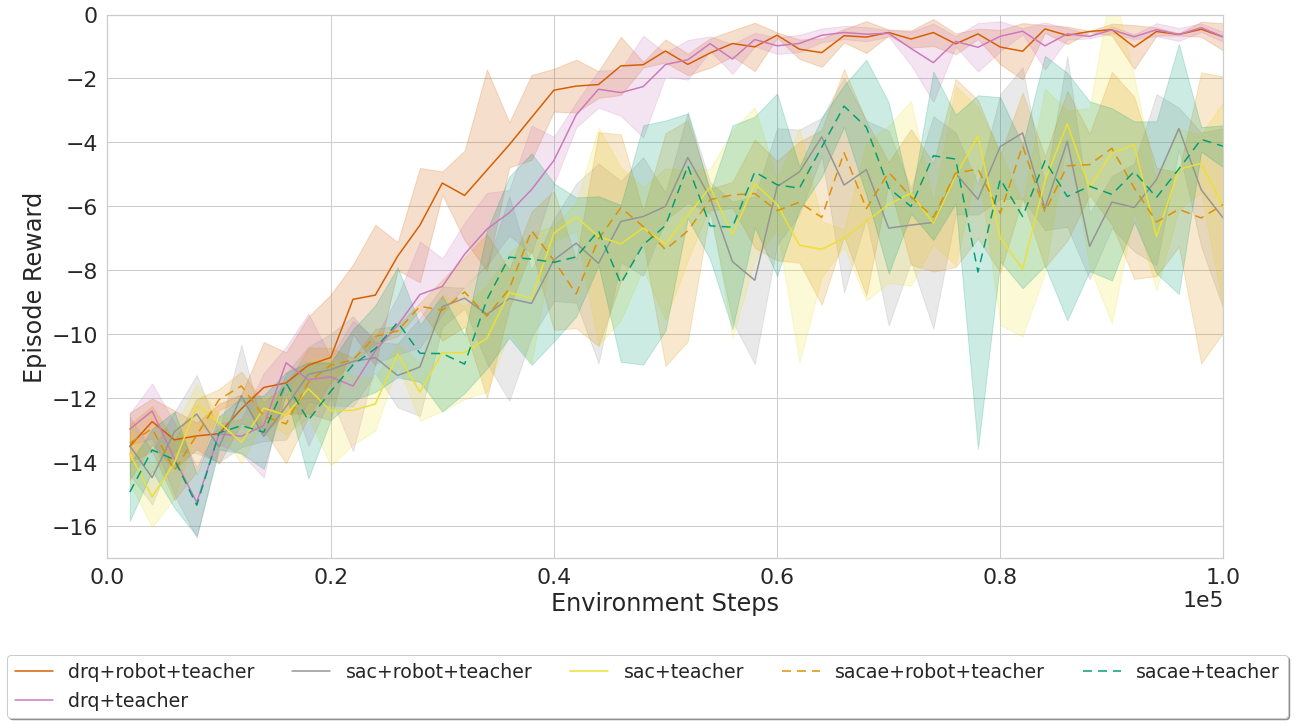

In [58]:
data = all_logs[all_logs['algo'].str.contains('teacher')]
plot(data[data['step'] % 2000 == 0], 'train/episode_reward', 'Episode Reward', -17, 0, image_name='results/reach/reward_teacher.png', color_palette=colors, dashes=dashes)

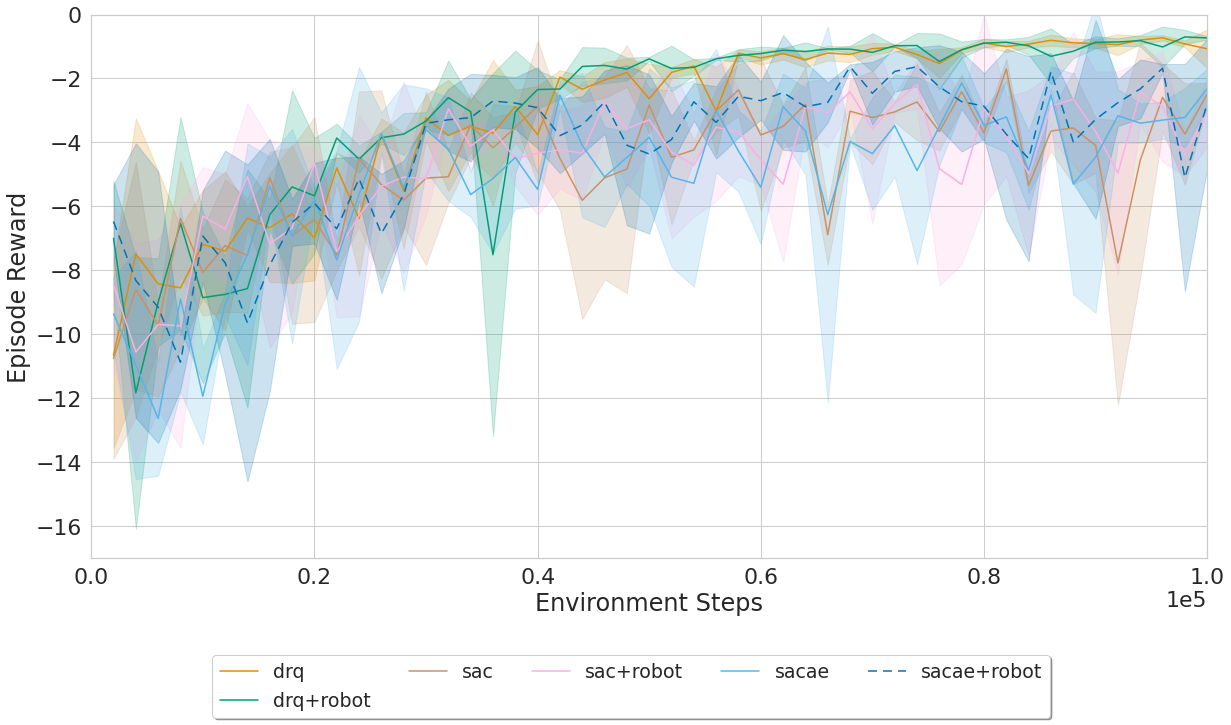

In [59]:
data = all_logs[~(all_logs['algo'].str.contains('teacher')) & (all_logs['algo'] != 'sac-state')]
plot(data[data['step'] % 2000 == 0], 'train/episode_reward', 'Episode Reward', -17, 0, image_name='results/reach/reward_no_teacher.png', color_palette=colors, dashes=dashes)

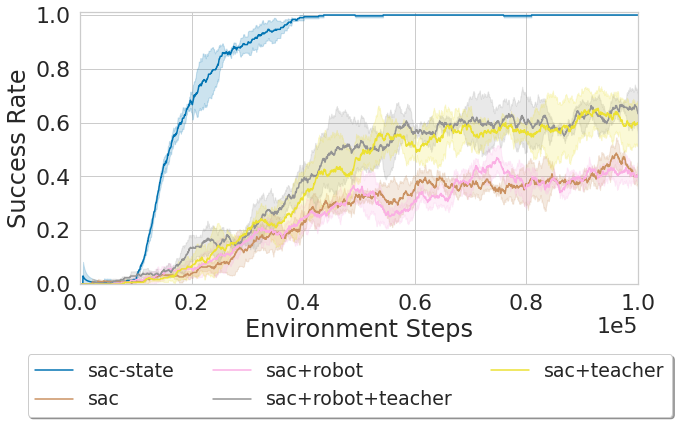

In [90]:
data = all_logs[all_logs['algo'].isin(['sac-state', 'sac', 'sac+robot', 'sac+teacher', 'sac+robot+teacher'])]
plot(data, 'train/success_rate', 'Success Rate', 0, 1.01, 'results/reach/sac_legend.png', colors, dashes, legend_offset=-0.27, legend_ncol=3, size=(10,5))#, False, (10,5))

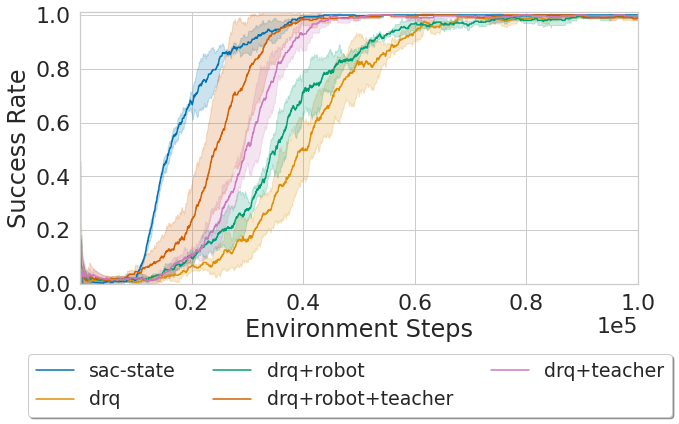

In [91]:
data = all_logs[all_logs['algo'].isin(['sac-state', 'drq', 'drq+robot', 'drq+teacher', 'drq+robot+teacher'])]
plot(data, 'train/success_rate', 'Success Rate', 0, 1.01, 'results/reach/drq_legend.png', colors, dashes, legend_offset=-0.27, legend_ncol=3, size=(10,5))#, False, (10,5))

In [6]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [12]:
rgb_to_hex(tuple([int(255*x) for x in colors['drq']]))

'de8f05'